### Importing dependencies


In [ ]:
import re
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

### Utility functions

In [ ]:
# The below functions add percentages on top of bars in bar charts

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [ ]:
def decontracted(phrase):
    '''This function decontracts words to their original form: 
       Eg won't >> will not'''
       
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

### Data pre-processing

In [ ]:
# Reading dataset
df = pd.read_csv('/content/drive/MyDrive/Case_Study_2/train-balanced-sarcasm.csv', low_memory=False)
print(df.shape)
df.head()

(1010827, 10)


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2.0,-1.0,-1.0,2016-10,16-10-2016 23:55,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4.0,-1.0,-1.0,2016-11,01-11-2016 00:24,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3.0,3.0,0.0,2016-09,22-09-2016 21:45,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8.0,-1.0,-1.0,2016-10,18-10-2016 21:03,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6.0,-1.0,-1.0,2016-12,30-12-2016 17:00,Yep can confirm I saw the tool they use for th...


In [ ]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [ ]:
df.isnull().sum()

label              0
comment           54
author             1
subreddit          1
score              1
ups                1
downs              1
date               1
created_utc        1
parent_comment     1
dtype: int64

Since there are a million rows in the dataset and max no. of rows with missing values is just 54 we can drop them.

In [ ]:
# dropping missing values
df = df.dropna()
print(df.shape)
df.isnull().sum()

(1010773, 10)


label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [ ]:
# data type of each column
df.dtypes

label              object
comment            object
author             object
subreddit          object
score             float64
ups               float64
downs             float64
date               object
created_utc        object
parent_comment     object
dtype: object

The data type for label column should be int, and data types for create_utc and date should be datetime.

In [ ]:
# Converting data to right format
df = df.astype({'label': 'int64'})
df[["date", "created_utc"]] = df[["date", "created_utc"]].apply(pd.to_datetime)
df.dtypes

label                      int64
comment                   object
author                    object
subreddit                 object
score                    float64
ups                      float64
downs                    float64
date              datetime64[ns]
created_utc       datetime64[ns]
parent_comment            object
dtype: object

In [ ]:
# pre-processing comment column
df['comment'] = df['comment'].str.lower()
df['comment'] = df['comment'].apply(decontracted)
df['comment'] = df['comment'].str.replace('[^\w\s]','')

# pre-processing parent_comment column
df['parent_comment'] = df['parent_comment'].str.lower()
df['parent_comment'] = df['parent_comment'].apply(decontracted)
df['parent_comment'] = df['parent_comment'].str.replace('[^\w\s]','')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc and nh,Trumpbart,politics,2.0,-1.0,-1.0,2016-10-01,2016-10-16 23:55:00,yeah i get that argument at this point i would...
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4.0,-1.0,-1.0,2016-11-01,2016-01-11 00:24:00,the blazers and mavericks the wests 5 and 6 se...
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3.0,3.0,0.0,2016-09-01,2016-09-22 21:45:00,they are favored to win
3,0,this meme is not funny none of the new york ni...,icebrotha,BlackPeopleTwitter,-8.0,-1.0,-1.0,2016-10-01,2016-10-18 21:03:00,deadass do not kill my buzz
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6.0,-1.0,-1.0,2016-12-01,2016-12-30 17:00:00,yep can confirm i saw the tool they use for th...


In [ ]:
# Save pre-processed file
df.to_csv('/content/drive/MyDrive/Case_Study_2/pre_processed.csv')

### Exploratory Data Analysis

**1. What is the distribution of label column?**

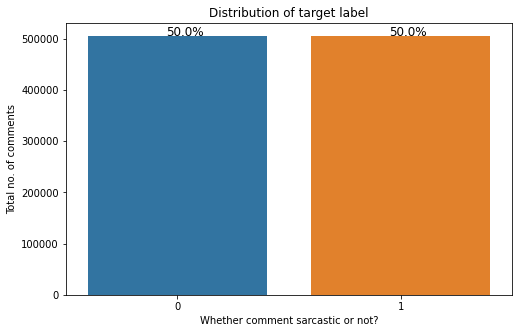

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df)
plt.xlabel('Whether comment sarcastic or not?')
plt.ylabel('Total no. of comments')
plt.title('Distribution of target label')
without_hue(ax, df.label)

**Observations**
1. The given dataset is perfectly balanced with nearly 0.5M sarcastic and non sarcastic comments.

**2. What is the distribution of length of sarcastic and non-sarcastic comments?**

In [ ]:
# find length of each comment
df['comment_length'] = df['comment'].apply(lambda x: len(x.split()))

In [ ]:
# drop rows with empty comments
indices = df[df['comment_length'] == 0].index
df = df.drop(indices, axis=0)

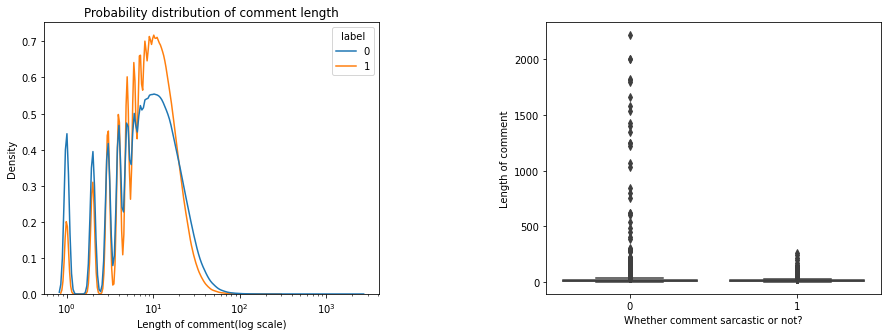

In [ ]:
f, axs = plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
sns.kdeplot(x='comment_length', hue='label', log_scale=True, data=df)
plt.title("Probability distribution of comment length")
plt.xlabel("Length of comment(log scale)")
plt.ylabel("Density")

plt.subplot(1,2,2)
sns.boxplot(x='label', y='comment_length', data=df)
plt.ylabel("Length of comment")
plt.xlabel('Whether comment sarcastic or not?')
plt.subplots_adjust(wspace=0.5)
plt.show()

**Observations**
1. The distribution of length of comments on Reddit is right skewed where majority of the comments are short.
2. There is an overlap between distribution of length of sarcastic and non sarcastic comments.
3. We can't predict if a comment is sarcastic or not based on it's length.

**3. Word cloud for all sarcastic comments**

In [ ]:
comments_non_sarcastic = df[df['label'] == 0].comment.values
comments_sarcastic = df[df['label'] == 1].comment.values

In [ ]:
# all wods for sarcastic comments
words_sarcastic = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for sentence in comments_sarcastic:
     
    # typecaste each val to string
    sentence = str(sentence)
 
    # split the value
    tokens = sentence.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    words_sarcastic += " ".join(tokens) + " "

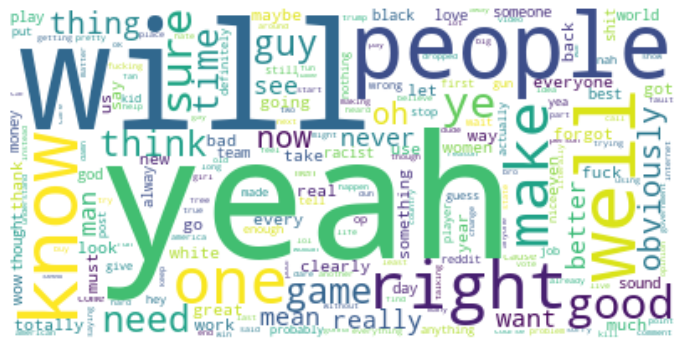

In [ ]:
# Creating word_cloud for sarcastic comments
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words_sarcastic)
# Display the generated Word Cloud
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**4. Word cloud for all non sarcastic comments**

In [ ]:
# all words for sarcastic comments
words_non_sarcastic = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for sentence in comments_non_sarcastic:
     
    # typecaste each val to string
    sentence = str(sentence)
 
    # split the value
    tokens = sentence.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    words_non_sarcastic += " ".join(tokens) + " "

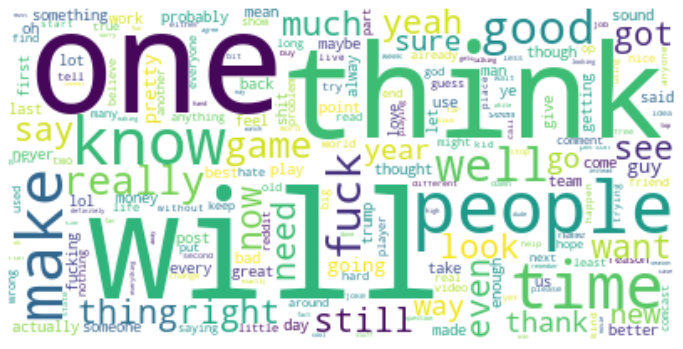

In [ ]:
# Creating word_cloud for non sarcastic comments
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words_non_sarcastic)
# Display the generated Word Cloud
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Observations**
1. Top most words in both sarcastic and non sarcastic comments are almost same.
2. It is very difficult to distinguish sarcastic and non sarcastic comments based on the words used.

In [ ]:
# Total no. of unique users who have commented on Reddit
print("Total no. of unique users who have commented on Reddit: ", len(np.unique(df.author)))

Total no. of unique users who have commented on Reddit:  256388


In [ ]:
# Total no. of topics discussed on Reddit
print("Total no. of topics(subreddit) on Reddit: ", len(np.unique(df.subreddit)))

Total no. of topics(subreddit) on Reddit:  14863


**4. Number of sarcastic comments for each subreddit**

In [ ]:
sarcastic_per_topic = df[df['label'] == 1].groupby(['subreddit']).author\
                      .count().reset_index().sort_values(by=['author'], 
                       ascending=False).rename(columns={'author':'sarcastic_comments'})
sarcastic_per_topic['proportion'] = sarcastic_per_topic['sarcastic_comments']/sum(sarcastic_per_topic['sarcastic_comments'])*100
sarcastic_per_topic.head()

,subreddit,sarcastic_comments,proportion
355,AskReddit,26350,5.215715
7587,politics,23903,4.731356
8907,worldnews,16945,3.354091
6768,leagueoflegends,11399,2.256316
7468,pcmasterrace,10757,2.129239


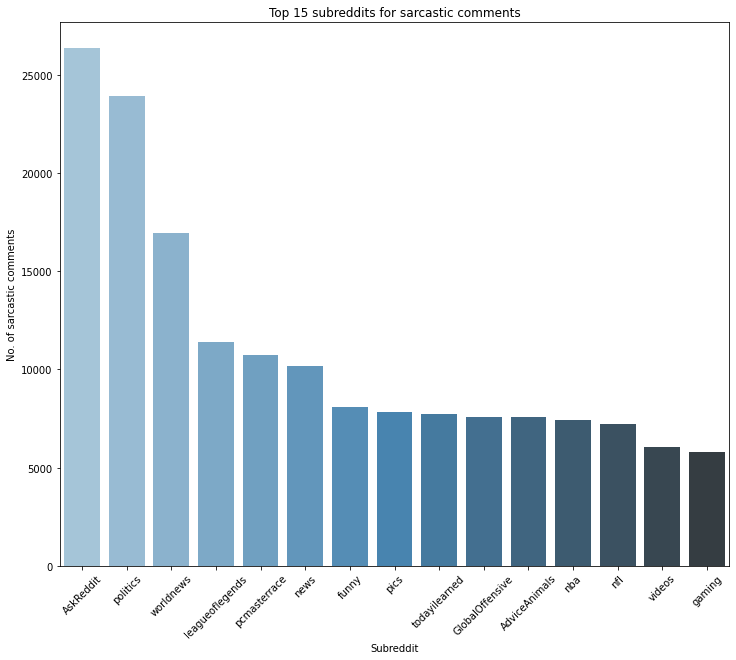

In [ ]:
# Top 15 subreddits for sarcastic comments
plt.figure(figsize=(12, 10))
top_15 = sarcastic_per_topic.iloc[:15]
sns.barplot(x='subreddit', y='sarcastic_comments', palette=("Blues_d"), data=top_15)
plt.title('Top 15 subreddits for sarcastic comments')
plt.xlabel('Subreddit')
plt.ylabel('No. of sarcastic comments')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

**5. No. of non sarcastic comments for each subreddit**

In [ ]:
nonsarcastic_per_topic = df[df['label'] == 0].groupby(['subreddit']).author\
                      .count().reset_index().sort_values(by=['author'], 
                       ascending=False).rename(columns={'author':'nonsarcastic_comments'})
nonsarcastic_per_topic['proportion'] = nonsarcastic_per_topic['nonsarcastic_comments']/sum(nonsarcastic_per_topic['nonsarcastic_comments'])*100
nonsarcastic_per_topic.head()

,subreddit,nonsarcastic_comments,proportion
516,AskReddit,39252,7.779960
10852,politics,15584,3.088834
8816,funny,9824,1.947170
9712,leagueoflegends,9607,1.904160
12689,worldnews,9420,1.867095


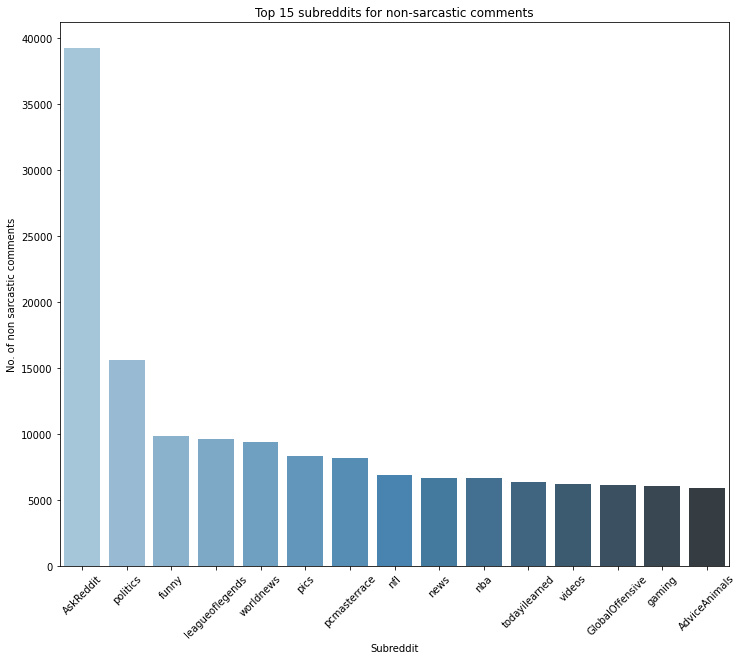

In [ ]:
# Top 15 subreddits for non sarcastic comments
plt.figure(figsize=(12, 10))
top_15 = nonsarcastic_per_topic.iloc[:15]
sns.barplot(x='subreddit', y='nonsarcastic_comments', palette=("Blues_d"), data=top_15)
plt.title('Top 15 subreddits for non-sarcastic comments')
plt.xlabel('Subreddit')
plt.ylabel('No. of non sarcastic comments')
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

**Observations**
1. Most no. of sarcastic and non sarcastic comments have been made for AskReddit subreddit.
2. Top 15 subreddits for both sarcastic and non sarcastic comments are same.
3. If a comment is made under AskReddit subreddit, the chances of it being sarcastic is 7.77%.

**6. Comparing popularity score of sarcastic and non sarcastic comments**

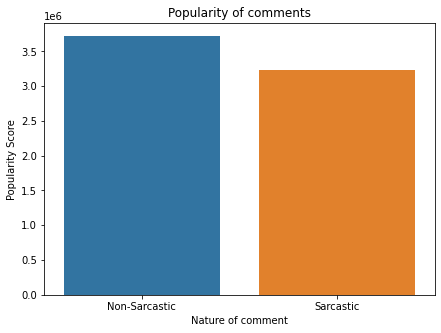

In [ ]:
plt.figure(figsize=(7, 5))
scores = df.groupby(['label']).score.sum().reset_index()
scores['label'] = scores['label'].replace({0:'Non-Sarcastic', 1:'Sarcastic'})     
sns.barplot(x='label', y='score', data=scores)
plt.xlabel('Nature of comment')
plt.ylabel('Popularity Score')
plt.title('Popularity of comments')
plt.show()

**Observation**
1. The total popularity score of sarcastic comments is lesser than normal comments.

**7. Total comments and sarcastic comments made in each year**

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Total comments made on reddit each year
total_comments = df.groupby(['year']).label.count()\
                 .reset_index().rename(columns={'label':'total_comments'})

# Total sarcastic comments made on reddit each year
sarcastic_comments = df[df['label']==1].groupby(['year']).label.count()\
                     .reset_index().rename(columns={'label':'sarcastic_comments'})

# Merging sarcastic comments and non-sarcastic comments
comments = total_comments.merge(sarcastic_comments, on='year')

# Ratio of sarcastic comments to total comments every year
comments['ratio'] = comments['sarcastic_comments']/comments['total_comments']
comments

,year,total_comments,sarcastic_comments,ratio
0,2009,1850,1078,0.582703
1,2010,5276,2976,0.564064
2,2011,12713,6943,0.546134
3,2012,27279,14582,0.534550
4,2013,63500,34177,0.538220
5,2014,137398,73490,0.534870
6,2015,286566,149253,0.520833
7,2016,475149,222705,0.468706


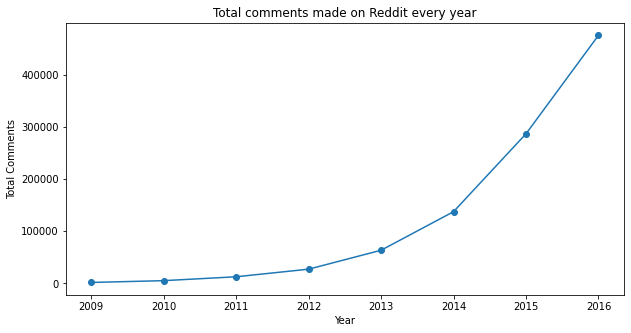

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(comments['year'], comments['total_comments'], marker='o')
plt.xlabel('Year')
plt.ylabel('Total Comments')
plt.title('Total comments made on Reddit every year')
plt.show()

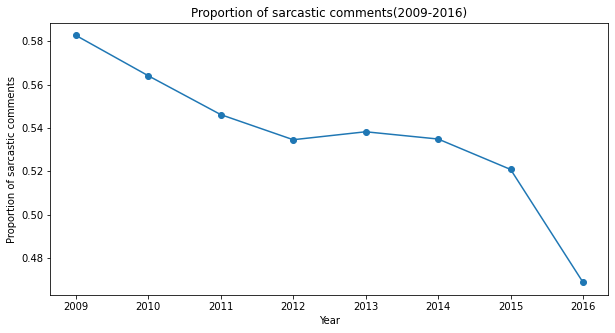

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(comments['year'], comments['ratio'], marker='o')
plt.xlabel('Year')
plt.ylabel('Proportion of sarcastic comments')
plt.title('Proportion of sarcastic comments(2009-2016)')
plt.show()

**Observations**
1. The no. of comments on Reddit have increased exponentially from 2009-2016.
2. Though the no. of comments have increased from 2009 to 2016, the proportion of sarcastic comments has decreased. 
3. The new users, mostly from younger generations may use sarcasm less frequently.

In [ ]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_length,year,month
0,0,nc and nh,Trumpbart,politics,2.0,-1.0,-1.0,2016-10-01,2016-10-16 23:55:00,yeah i get that argument at this point i would...,3,2016,10
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4.0,-1.0,-1.0,2016-11-01,2016-01-11 00:24:00,the blazers and mavericks the wests 5 and 6 se...,14,2016,11
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3.0,3.0,0.0,2016-09-01,2016-09-22 21:45:00,they are favored to win,20,2016,9
3,0,this meme is not funny none of the new york ni...,icebrotha,BlackPeopleTwitter,-8.0,-1.0,-1.0,2016-10-01,2016-10-18 21:03:00,deadass do not kill my buzz,13,2016,10
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6.0,-1.0,-1.0,2016-12-01,2016-12-30 17:00:00,yep can confirm i saw the tool they use for th...,7,2016,12


**8. length of parent comment vs length of reply on parent comment**

In [ ]:
# length of parent comment
df['parent_length'] = df['parent_comment'].apply(lambda x: len(x.split()))
# difference of length between parent coment and reply on parent comment
df['diff_length'] = df['parent_length'] - df['comment_length']
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_length,year,month,parent_length,diff_length
0,0,nc and nh,Trumpbart,politics,2.0,-1.0,-1.0,2016-10-01,2016-10-16 23:55:00,yeah i get that argument at this point i would...,3,2016,10,18,15
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4.0,-1.0,-1.0,2016-11-01,2016-01-11 00:24:00,the blazers and mavericks the wests 5 and 6 se...,14,2016,11,27,13
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3.0,3.0,0.0,2016-09-01,2016-09-22 21:45:00,they are favored to win,20,2016,9,5,-15
3,0,this meme is not funny none of the new york ni...,icebrotha,BlackPeopleTwitter,-8.0,-1.0,-1.0,2016-10-01,2016-10-18 21:03:00,deadass do not kill my buzz,13,2016,10,6,-7
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6.0,-1.0,-1.0,2016-12-01,2016-12-30 17:00:00,yep can confirm i saw the tool they use for th...,7,2016,12,18,11


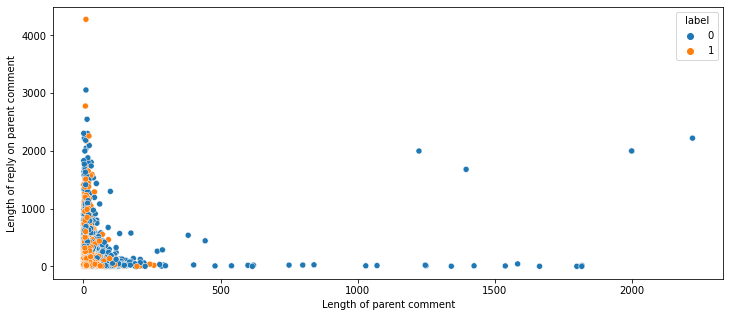

In [ ]:
plt.figure(figsize=(12, 5))
df['parent_length'] = df['parent_comment'].apply(lambda x: len(x.split()))
sns.scatterplot(x='comment_length', y='parent_length', hue='label', data=df)
plt.xlabel('Length of parent comment')
plt.ylabel('Length of reply on parent comment')
plt.show()

**Observation**
1. Replies on parent comment are usually longer than the parent comment.
2. However, the 2 features when visualized together are not able to separate the target variable into distinct classes. There is a huge overlap.

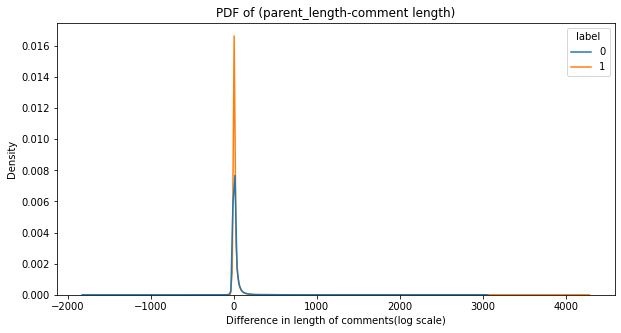

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(x='diff_length', hue='label', data=df)
plt.title("PDF of (parent_length-comment length)")
plt.xlabel("Difference in length of comments")
plt.ylabel("Density")
plt.show()

**Observations**
1. There is an overlap in the region between sarcastic and normal comments in the pdf of difference in length of comments.
2. Difference in length of parent comment and reply on parent comment is not an important indicator variable to predict if a comment is sarcastic.

In [ ]:
# Dataframe with all new features
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_length,year,month,parent_length,diff_length
0,0,nc and nh,Trumpbart,politics,2.0,-1.0,-1.0,2016-10-01,2016-10-16 23:55:00,yeah i get that argument at this point i would...,3,2016,10,18,15
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4.0,-1.0,-1.0,2016-11-01,2016-01-11 00:24:00,the blazers and mavericks the wests 5 and 6 se...,14,2016,11,27,13
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3.0,3.0,0.0,2016-09-01,2016-09-22 21:45:00,they are favored to win,20,2016,9,5,-15
3,0,this meme is not funny none of the new york ni...,icebrotha,BlackPeopleTwitter,-8.0,-1.0,-1.0,2016-10-01,2016-10-18 21:03:00,deadass do not kill my buzz,13,2016,10,6,-7
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6.0,-1.0,-1.0,2016-12-01,2016-12-30 17:00:00,yep can confirm i saw the tool they use for th...,7,2016,12,18,11


In [ ]:
# Save dataframe with new features
df.to_csv('/content/drive/MyDrive/Case_Study_2/pre_processed2.csv')